In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
from KMlib.metrics import total_score
from KMlib.plot_metrics import plot_loss,plot_test
from KMlib.processing import pr_scaling,x_scaling,Processer,get_test_data

In [4]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [23]:
def get_p_model(train,valid, epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True,input_shape = [WINDOW_SIZE, px_train.shape[1]]),
    # tf.keras.layers.LSTM(64, return_sequences=True),   
    tf.keras.layers.LSTM(64, return_sequences=False),   
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0003)
    early_stopping = EarlyStopping('loss', patience=10)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0, 
                        validation_data=valid, callbacks=[early_stopping])    
    return model, history
def get_r_model(train, valid,  epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True,input_shape = [WINDOW_SIZE, px_train.shape[1]]),
    # tf.keras.layers.LSTM(64, return_sequences=True),   
    tf.keras.layers.LSTM(64, return_sequences=False),   
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0003)
    early_stopping = EarlyStopping('loss', patience=10)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,
                        validation_data=valid, callbacks=[early_stopping])
    return model, history

In [29]:
# change file here
m = 'r_4'
df_rich = pd.read_csv(r'../data/the_rich_r_4.csv',index_col = 0)
df_poor = pd.read_csv(r'../data/the_poor_r_4.csv',index_col = 0)
## get true test value
df = pd.read_csv(r'../data/complete_feature.csv',index_col = 0)
purchase_true = df.loc["2014-08-02":"2014-08-31"].iloc[:, 0]
redeem_true = df.loc["2014-08-02":"2014-08-31"].iloc[:, 1]
df_train = df.loc[:"2014-08-01"]
col = ['total_purchase_amt', 'consume_amt', 'transfer_amt','month', 'day', 'weekday', 'dis_to_nowork',
      'dis_from_nowork', 'dis_to_work',
       'dis_from_work', 'dis_from_holiday', 'dis_to_holiendday',
       'dis_from_holiendday', 'dis_from_endofweek', 'dis_from_purchase_peak',
       'dis_from_purchase_valley', 'user_id',  'weekday_onehot_0', 'weekday_onehot_1', 'weekday_onehot_2',
       'weekday_onehot_3', 'weekday_onehot_4', 'weekday_onehot_5',
       'weekday_onehot_6']  # user id is user count
df_train = df_train[col]

In [30]:
df_poor_train = df_poor.loc[:"2014-08-01",col]
df_rich_train = df_rich.loc[:"2014-08-01",col]
_,_,_,pp_scaler,prc_scaler,prt_scaler = pr_scaling(df_poor_train)
_,_,_,rp_scaler,rrc_scaler,rrt_scaler = pr_scaling(df_rich_train)
px_data,px_scaler =  x_scaling(df_poor_train)
rx_data,rx_scaler =  x_scaling(df_rich_train)

In [31]:
WINDOW_SIZE = 40
BATCH_SIZE = 16
SHUFFLE_BUFFER = 1000 
number_pred = 30
number_shift = 7
input_dimension = 3
L= Processer(WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER,number_pred,number_shift,input_dimension)
# Train-Valid Split 
px_train,px_valid = L.train_valid_split(px_data)
rx_train,rx_valid = L.train_valid_split(rx_data)

In [32]:
# get test data
df_poor_test = df_poor_train[-WINDOW_SIZE:]
df_rich_test = df_rich_train[-WINDOW_SIZE:]
px_test = px_scaler.transform(df_poor_test.values)
rx_test = rx_scaler.transform(df_rich_test.values)

In [33]:
p_col = list(df_poor.columns).index('total_purchase_amt')
c_col = list(df_poor.columns).index('consume_amt')
t_col = list(df_poor.columns).index('transfer_amt')
pp_tensor_train,pp_tensor_valid = L.get_tensor_dataset(px_train,y_col = p_col)
prc_tensor_train,prc_tensor_valid = L.get_tensor_dataset(px_train,y_col = c_col)
prt_tensor_train,prt_tensor_valid = L.get_tensor_dataset(px_train,y_col = t_col)
rp_tensor_train,rp_tensor_valid = L.get_tensor_dataset(rx_train,y_col = p_col)
rrc_tensor_train,rrc_tensor_valid = L.get_tensor_dataset(rx_train,y_col = c_col)
rrt_tensor_train,rrt_tensor_valid = L.get_tensor_dataset(rx_train,y_col = t_col)


## Model developing

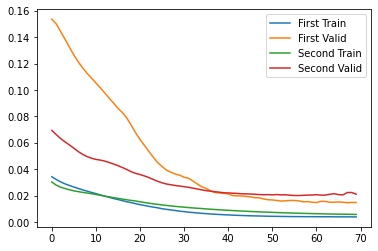

In [34]:
pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = 70 )
rp_model,rp_history =get_p_model(rp_tensor_train ,rp_tensor_valid,epochs = 70)
plot_loss(pp_history, rp_history)

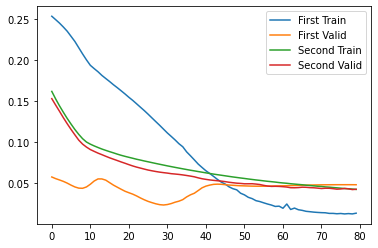

In [35]:
epochs = 80
prc_model,prc_history =get_r_model(prc_tensor_train,prc_tensor_valid,epochs = epochs)
prt_model,prt_history =get_r_model(prt_tensor_train,prt_tensor_valid,epochs = epochs)
plot_loss(prc_history,prt_history)

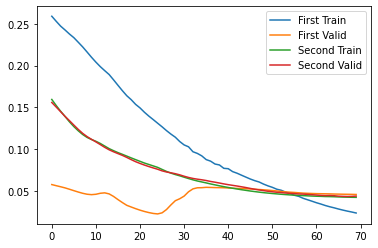

In [36]:
epochs = 70
rrc_model,rrc_history =get_r_model(rrc_tensor_train,rrc_tensor_valid,epochs = epochs)
rrt_model,rrt_history =get_r_model(rrt_tensor_train,rrt_tensor_valid,epochs =epochs)
plot_loss(rrc_history,rrt_history)

In [37]:
pp_pred = pp_scaler.inverse_transform(pp_model.predict(px_test[np.newaxis,...])).reshape(30,)
prc_pred = prc_scaler.inverse_transform(prc_model.predict(px_test[np.newaxis,...])).reshape(30,)
prt_pred = prt_scaler.inverse_transform(prt_model.predict(px_test[np.newaxis,...])).reshape(30,)
rp_pred = rp_scaler.inverse_transform(rp_model.predict(rx_test[np.newaxis,...])).reshape(30,)
rrc_pred = rrc_scaler.inverse_transform(rrc_model.predict(rx_test[np.newaxis,...])).reshape(30,)
rrt_pred = rrt_scaler.inverse_transform(rrt_model.predict(rx_test[np.newaxis,...])).reshape(30,)

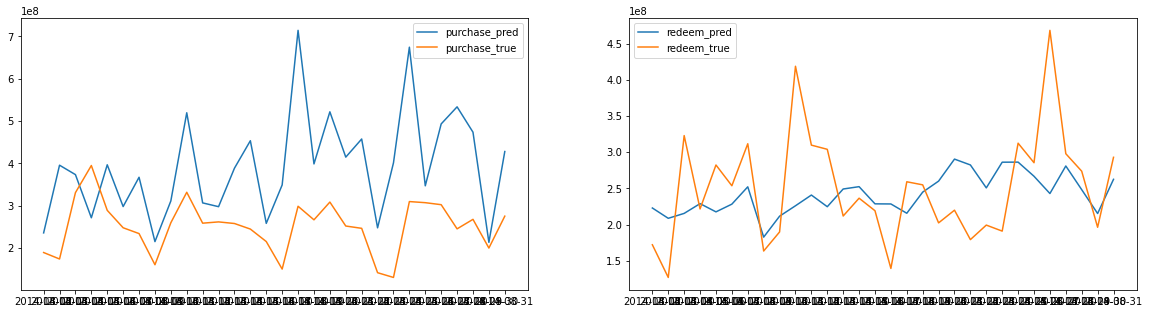

60.115125408991446

In [38]:
purchase_pred = pp_pred + rp_pred
redeem_pred = rrc_pred + rrt_pred + prt_pred + prc_pred
plot_test(purchase_pred,purchase_true,redeem_pred,redeem_true)
total_score(purchase_pred,purchase_true,redeem_pred,redeem_true)

# Final Comparing

## user grouped

In [ ]:
epochs = 80
score = []
for _ in tqdm(range(5)):
    pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = 80)
    rp_model,rp_history =get_p_model(rp_tensor_train ,rp_tensor_valid,epochs = 80)

    prc_model,prc_history =get_r_model(prc_tensor_train,prc_tensor_valid,epochs = epochs)
    prt_model,prt_history =get_r_model(prt_tensor_train,prt_tensor_valid,epochs = epochs)
    
    rrc_model,rrc_history =get_r_model(rrc_tensor_train,rrc_tensor_valid,epochs = epochs)
    rrt_model,rrt_history =get_r_model(rrt_tensor_train,rrt_tensor_valid,epochs = epochs)
    
    pp_pred = pp_scaler.inverse_transform(pp_model.predict(pp_test[np.newaxis,...])).reshape(30,)
    prc_pred = prc_scaler.inverse_transform(prc_model.predict(prc_test[np.newaxis,...])).reshape(30,)
    prt_pred = prt_scaler.inverse_transform(prt_model.predict(prt_test[np.newaxis,...])).reshape(30,)
    rp_pred = rp_scaler.inverse_transform(rp_model.predict(rp_test[np.newaxis,...])).reshape(30,)
    rrc_pred = rrc_scaler.inverse_transform(rrc_model.predict(rrc_test[np.newaxis,...])).reshape(30,)
    rrt_pred = rrt_scaler.inverse_transform(rrt_model.predict(rrt_test[np.newaxis,...])).reshape(30,)
    
    purchase_pred = pp_pred + rp_pred
    redeem_pred = rrc_pred + rrt_pred + prt_pred + prc_pred
    score.append(total_score(purchase_pred,purchase_true,redeem_pred,redeem_true))
score

## No user group

In [ ]:
df_train = df.loc[:"2014-08-01"]
p_data,rc_data,rt_data,p_scaler,rc_scaler,rt_scaler = x_scaling(df_train)

# train valid split
p_train,p_valid = C.train_valid_split(p_data)
rt_train,rt_valid = C.train_valid_split(rc_data)
rc_train,rc_valid = C.train_valid_split(rc_data)

# test split
df_test = df_train[-WINDOW_SIZE:]
p_test,rc_test,rt_test = get_test_data(df_test,p_scaler,rc_scaler,rt_scaler)

# generate tensor dataset
p_tensor_train,p_tensor_valid = C.get_tensor_dataset(p_data)
rc_tensor_train,rc_tensor_valid = C.get_tensor_dataset(rc_data)
rt_tensor_train,rt_tensor_valid = C.get_tensor_dataset(rt_data)

In [ ]:
epochs = 80
score = []
for _ in tqdm(range(5)):
    p_model,p_history =get_p_model(p_tensor_train ,p_tensor_valid,epochs = 100)
    rc_model,rc_history =get_r_model(rc_tensor_train,rc_tensor_valid,epochs = epochs)
    rt_model,rt_history =get_r_model(rt_tensor_train,rt_tensor_valid,epochs = epochs)
    
    p_pred = p_scaler.inverse_transform(p_model.predict(p_test[np.newaxis,...])).reshape(30,)
    rc_pred = rc_scaler.inverse_transform(rc_model.predict(rc_test[np.newaxis,...])).reshape(30,)
    rt_pred = rt_scaler.inverse_transform(rt_model.predict(rt_test[np.newaxis,...])).reshape(30,)

    
    purchase_pred = p_pred 
    redeem_pred = rc_pred + rt_pred
    score.append(total_score(purchase_pred,purchase_true,redeem_pred,redeem_true))
print(score)
print(np.mean(score))